<a href="https://colab.research.google.com/github/sakshamhooda/Benchmarking_Gemini_API_AccessLibraries/blob/main/Benchmarking_Gemini_API_Access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here in the notebook I intend to compare perfomance metrics when Google Gemini-API is called using newly launched OpenAI libray method as well as conventional Gemini-API.

https://developers.googleblog.com/en/gemini-is-now-accessible-from-the-openai-library/

This benchmark suite measures several key performance metrics:

1. Latency:

    - Response time for each API call
    - Standard deviation to measure consistency
    - Includes network transfer time


2. Memory Usage:

  - Memory consumption per request
  - Peak memory usage
  - Memory cleanup efficiency


2. Additional Features:

  - Multiple test prompts of varying complexity
  - Error handling and retry logic
  - Visualization of results
  - Statistical analysis of performance metrics



The benchmark uses 5 different types of prompts to test various aspects of the API:

- Short factual responses
- Code generation
- Literary analysis
- Scientific explanation
- Technical concepts



In [1]:
!pip install google-generativeai openai pandas matplotlib psutil

In [27]:
import time
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import google.generativeai as genai
import os
from datetime import datetime
import json
import sys
import psutil
import tracemalloc
import traceback
import gc

In [3]:
from google.colab import userdata
gemini_api_key = userdata.get('gemini-api-saksham')
os.environ['GEMINI_API_KEY'] = gemini_api_key

In [15]:
class APIPerformanceTester:
    def __init__(self, gemini_api_key):

        genai.configure(api_key=gemini_api_key)
        self.openai_client = OpenAI(
            api_key=gemini_api_key,
            base_url="https://generativelanguage.googleapis.com/v1beta/"
        )


        self.test_prompts = [
            "What is 2+2 and explain your reasoning",
            "List three benefits of exercise",
            "Explain what happens when water boils",
            "Describe a sunny day",
            "Count from 1 to 5"
        ]

        self.model_name = "gemini-1.5-flash"
        self.results = {
            'native': {'latency': [], 'memory': [], 'success': [], 'error_types': []},
            'openai': {'latency': [], 'memory': [], 'success': [], 'error_types': []}
        }

    def measure_performance(self, func, api_type):
        try:
            start_time = time.time()
            start_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

            response = func()

            end_time = time.time()
            end_memory = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

            self.results[api_type]['success'].append(True)
            self.results[api_type]['error_types'].append(None)

            return {
                'latency': end_time - start_time,
                'memory': end_memory - start_memory,
                'response': response,
                'success': True
            }

        except Exception as e:
            self.results[api_type]['success'].append(False)
            self.results[api_type]['error_types'].append(str(type(e).__name__))
            print(f"Error in {api_type} API: {str(e)}")
            return {
                'latency': 0,
                'memory': 0,
                'response': None,
                'success': False
            }

    def test_native_gemini(self, prompt):
        def execute():
            model = genai.GenerativeModel(model_name=self.model_name)
            response = model.generate_content(prompt)
            # Handle potential blocked response
            if response.candidates:
                return response.text
            return "Response blocked or empty"
        return self.measure_performance(execute, 'native')

    def test_openai_wrapper(self, prompt):
        def execute():
            response = self.openai_client.chat.completions.create(
                model=self.model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                n=1
            )
            return response.choices[0].message.content
        return self.measure_performance(execute, 'openai')

    def run_benchmark(self, iterations=5):
        print(f"Starting benchmark with {iterations} iterations per prompt...")

        for prompt in self.test_prompts:
            print(f"\nTesting prompt: {prompt}")

            for i in range(iterations):
                print(f"  Iteration {i+1}/{iterations}")

                # Test Native Gemini
                print("    Testing Native Gemini...")
                native_results = self.test_native_gemini(prompt)
                if native_results['success']:
                    self.results['native']['latency'].append(native_results['latency'])
                    self.results['native']['memory'].append(native_results['memory'])

                # Test OpenAI Wrapper
                print("    Testing OpenAI Wrapper...")
                openai_results = self.test_openai_wrapper(prompt)
                if openai_results['success']:
                    self.results['openai']['latency'].append(openai_results['latency'])
                    self.results['openai']['memory'].append(openai_results['memory'])

                # Small delay between requests
                time.sleep(2)

    def generate_report(self):
        def safe_stats(data):
            if not data:
                return {'avg': 0, 'std': 0}
            return {
                'avg': statistics.mean(data) if len(data) > 0 else 0,
                'std': statistics.stdev(data) if len(data) > 1 else 0
            }

        native_stats = {
            'latency': safe_stats(self.results['native']['latency']),
            'memory': safe_stats(self.results['native']['memory']),
            'success_rate': sum(self.results['native']['success']) / len(self.results['native']['success']) * 100
        }

        openai_stats = {
            'latency': safe_stats(self.results['openai']['latency']),
            'memory': safe_stats(self.results['openai']['memory']),
            'success_rate': sum(self.results['openai']['success']) / len(self.results['openai']['success']) * 100
        }

        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        labels = ['Native Gemini', 'OpenAI Wrapper']

        # Latency comparison
        latencies = [native_stats['latency']['avg'], openai_stats['latency']['avg']]
        ax1.bar(labels, latencies)
        ax1.set_title('Average Latency')
        ax1.set_ylabel('Seconds')

        # Memory usage comparison
        memories = [native_stats['memory']['avg'], openai_stats['memory']['avg']]
        ax2.bar(labels, memories)
        ax2.set_title('Average Memory Usage')
        ax2.set_ylabel('MB')

        # Success rate comparison
        success_rates = [native_stats['success_rate'], openai_stats['success_rate']]
        ax3.bar(labels, success_rates)
        ax3.set_title('Success Rate')
        ax3.set_ylabel('Percentage')

        plt.tight_layout()

        return {'native': native_stats, 'openai': openai_stats}, fig

In [16]:
def run_api_benchmark(api_key):

    tester = APIPerformanceTester(api_key)
    tester.run_benchmark(iterations=3)  # Reduced iterations for initial testing
    report, fig = tester.generate_report()

    print("\nPerformance Report:")
    print("==================")
    print("\nNative Gemini API:")
    print(f"Success Rate: {report['native']['success_rate']:.1f}%")
    print(f"Average Latency: {report['native']['latency']['avg']:.2f}s (±{report['native']['latency']['std']:.2f}s)")
    print(f"Average Memory Usage: {report['native']['memory']['avg']:.2f}MB (±{report['native']['memory']['std']:.2f}MB)")

    print("\nOpenAI Wrapper:")
    print(f"Success Rate: {report['openai']['success_rate']:.1f}%")
    print(f"Average Latency: {report['openai']['latency']['avg']:.2f}s (±{report['openai']['latency']['std']:.2f}s)")
    print(f"Average Memory Usage: {report['openai']['memory']['avg']:.2f}MB (±{report['openai']['memory']['std']:.2f}MB)")

    plt.show()

    return report, fig

Starting benchmark with 3 iterations per prompt...

Testing prompt: What is 2+2 and explain your reasoning
  Iteration 1/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...

Testing prompt: List three benefits of exercise
  Iteration 1/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...

Testing prompt: Explain what happens when water boils
  Iteration 1/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...

Testing prompt: Describe a sunny day
  Iteration 1/3
    Testing Native Gemini...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
Error in openai API: Error code: 429 - [{'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}]
  Iteration 2/3
    Testing Native Gemini...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
Error in openai API: Error code: 429 - [{'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}]
  Iteration 3/3
    Testing Native Gemini...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
Error in openai API: Error code: 429 - [{'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}]

Testing prompt: Count from 1 to 5
  Iteration 1/3
    Testing Native Gemini...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini...
    Testing OpenAI Wrapper...

Performance Report:

Native Gemini API:
Success Rate: 66.7%
Average Latency: 1.77s (±0.74s)
Average Memory Usage: 0.00MB (±0.00MB)

OpenAI Wrapper:
Success Rate: 80.0%
Average Latency: 0.99s (±0.79s)
Average Memory Usage: 0.00MB (±0.00MB)


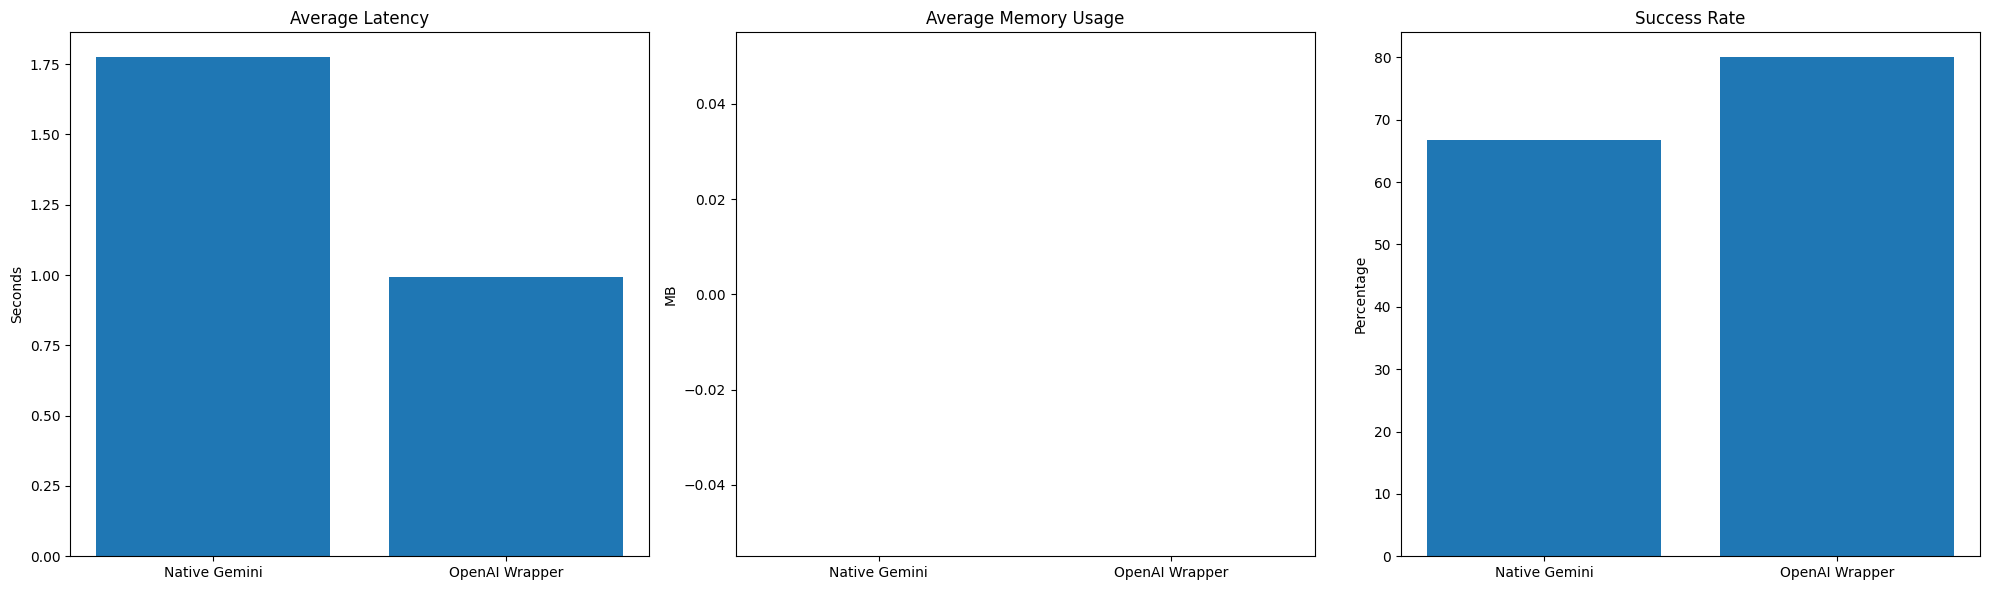

In [17]:
report, fig = run_api_benchmark(gemini_api_key)

optimising for memory sensitivity

In [28]:
import time
import statistics
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import google.generativeai as genai
import os
import tracemalloc
import gc
import traceback
from datetime import datetime
import json

class APIPerformanceTester:
    def __init__(self, gemini_api_key):
        # Initialize both clients
        genai.configure(api_key=gemini_api_key)
        self.openai_client = OpenAI(
            api_key=gemini_api_key,
            base_url="https://generativelanguage.googleapis.com/v1beta/"
        )

        self.test_prompts = [
            "What is 2+2 and explain your reasoning",
            "List three benefits of exercise",
            "Explain what happens when water boils",
            "Describe a sunny day",
            "Count from 1 to 5"
        ]

        self.model_name = "gemini-1.5-flash"
        self.results = {
            'native': {
                'latency': [],
                'memory': [],
                'success': [],
                'peak_memory': [],
                'responses': []
            },
            'openai': {
                'latency': [],
                'memory': [],
                'success': [],
                'peak_memory': [],
                'responses': []
            }
        }

        self.test_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    def measure_performance(self, func, api_type):
        try:
            # Enable memory tracking
            tracemalloc.start()
            gc.collect()  # Force garbage collection

            start_time = time.time()
            start_snapshot = tracemalloc.take_snapshot()

            response = func()

            end_time = time.time()
            end_snapshot = tracemalloc.take_snapshot()

            # Calculate memory statistics
            memory_diff = end_snapshot.compare_to(start_snapshot, 'lineno')
            total_memory = sum(stat.size_diff for stat in memory_diff) / 1024  # KB
            peak_memory = tracemalloc.get_traced_memory()[1] / 1024  # Peak memory in KB

            tracemalloc.stop()

            self.results[api_type]['success'].append(True)
            self.results[api_type]['peak_memory'].append(peak_memory)
            self.results[api_type]['responses'].append(response)

            return {
                'latency': end_time - start_time,
                'memory': total_memory,
                'peak_memory': peak_memory,
                'response': response,
                'success': True
            }

        except Exception as e:
            tracemalloc.stop()
            self.results[api_type]['success'].append(False)
            self.results[api_type]['responses'].append(str(e))
            print(f"Error in {api_type} API: {str(e)}")
            return {
                'latency': 0,
                'memory': 0,
                'peak_memory': 0,
                'response': None,
                'success': False
            }

    def test_native_gemini(self, prompt):
        def execute():
            model = genai.GenerativeModel(model_name=self.model_name)
            response = model.generate_content(prompt)
            if response.candidates:
                return response.text
            return "Response blocked or empty"
        return self.measure_performance(execute, 'native')

    def test_openai_wrapper(self, prompt):
        def execute():
            response = self.openai_client.chat.completions.create(
                model=self.model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                n=1
            )
            return response.choices[0].message.content
        return self.measure_performance(execute, 'openai')

    def run_benchmark(self, iterations=5):
        print(f"Starting benchmark with {iterations} iterations per prompt...")

        for i, prompt in enumerate(self.test_prompts):
            print(f"\nPrompt {i+1}/{len(self.test_prompts)}: {prompt}")

            for iteration in range(iterations):
                print(f"  Iteration {iteration+1}/{iterations}")

                # Test Native Gemini
                print("    Testing Native Gemini API...")
                native_results = self.test_native_gemini(prompt)
                if native_results['success']:
                    self.results['native']['latency'].append(native_results['latency'])
                    self.results['native']['memory'].append(native_results['memory'])

                # Test OpenAI Wrapper
                print("    Testing OpenAI Wrapper...")
                openai_results = self.test_openai_wrapper(prompt)
                if openai_results['success']:
                    self.results['openai']['latency'].append(openai_results['latency'])
                    self.results['openai']['memory'].append(openai_results['memory'])

                # Delay between requests to avoid rate limiting
                time.sleep(2)

    def generate_report(self):
        def safe_stats(data):
            if not data:
                return {'avg': 0, 'std': 0, 'min': 0, 'max': 0}
            return {
                'avg': statistics.mean(data) if len(data) > 0 else 0,
                'std': statistics.stdev(data) if len(data) > 1 else 0,
                'min': min(data) if data else 0,
                'max': max(data) if data else 0
            }

        native_stats = {
            'latency': safe_stats(self.results['native']['latency']),
            'memory': safe_stats(self.results['native']['memory']),
            'peak_memory': safe_stats(self.results['native']['peak_memory']),
            'success_rate': sum(self.results['native']['success']) / len(self.results['native']['success']) * 100
        }

        openai_stats = {
            'latency': safe_stats(self.results['openai']['latency']),
            'memory': safe_stats(self.results['openai']['memory']),
            'peak_memory': safe_stats(self.results['openai']['peak_memory']),
            'success_rate': sum(self.results['openai']['success']) / len(self.results['openai']['success']) * 100
        }

        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        labels = ['Native Gemini', 'OpenAI Wrapper']

        # Latency comparison
        axes[0, 0].bar(labels, [native_stats['latency']['avg'], openai_stats['latency']['avg']])
        axes[0, 0].set_title('Average Latency (seconds)')
        axes[0, 0].set_ylabel('Seconds')

        # Memory usage comparison
        axes[0, 1].bar(labels, [native_stats['memory']['avg'], openai_stats['memory']['avg']])
        axes[0, 1].set_title('Average Memory Usage (KB)')
        axes[0, 1].set_ylabel('Kilobytes')

        # Peak memory comparison
        axes[1, 0].bar(labels, [native_stats['peak_memory']['avg'], openai_stats['peak_memory']['avg']])
        axes[1, 0].set_title('Peak Memory Usage (KB)')
        axes[1, 0].set_ylabel('Kilobytes')

        # Success rate comparison
        axes[1, 1].bar(labels, [native_stats['success_rate'], openai_stats['success_rate']])
        axes[1, 1].set_title('Success Rate (%)')
        axes[1, 1].set_ylabel('Percentage')

        plt.tight_layout()

        # Save results to file
        results_file = f'benchmark_results_{self.test_timestamp}.json'
        with open(results_file, 'w') as f:
            json.dump({
                'native': native_stats,
                'openai': openai_stats,
                'metadata': {
                    'timestamp': self.test_timestamp,
                    'total_prompts': len(self.test_prompts),
                    'prompts': self.test_prompts
                }
            }, f, indent=2)

        return {'native': native_stats, 'openai': openai_stats}, fig

In [29]:
def print_detailed_report(report):
    """Print a detailed performance report"""
    print("\nDetailed Performance Report:")
    print("===========================")

    for api_type in ['native', 'openai']:
        print(f"\n{api_type.upper()} API:")
        print(f"Success Rate: {report[api_type]['success_rate']:.1f}%")

        print("\nLatency (seconds):")
        print(f"  Average: {report[api_type]['latency']['avg']:.3f}")
        print(f"  Std Dev: {report[api_type]['latency']['std']:.3f}")
        print(f"  Range: {report[api_type]['latency']['min']:.3f} - {report[api_type]['latency']['max']:.3f}")

        print("\nMemory Usage (KB):")
        print(f"  Average: {report[api_type]['memory']['avg']:.2f}")
        print(f"  Peak: {report[api_type]['peak_memory']['avg']:.2f}")
        print(f"  Range: {report[api_type]['memory']['min']:.2f} - {report[api_type]['memory']['max']:.2f}")

def run_complete_benchmark(api_key, iterations=3):
    """Main function to run the complete benchmark"""
    print("Initializing performance test...")
    tester = APIPerformanceTester(api_key)

    print(f"\nRunning benchmark with {iterations} iterations...")
    tester.run_benchmark(iterations=iterations)

    print("\nGenerating performance report...")
    report, fig = tester.generate_report()

    print_detailed_report(report)
    plt.show()

    return report, fig, tester.results

Initializing performance test...

Running benchmark with 3 iterations...
Starting benchmark with 3 iterations per prompt...

Prompt 1/5: What is 2+2 and explain your reasoning
  Iteration 1/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...

Prompt 2/5: List three benefits of exercise
  Iteration 1/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...

Prompt 3/5: Explain what happens when water boils
  Iteration 1/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...

Prompt 4/5: Desc

Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini API...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...
Error in openai API: Error code: 429 - [{'error': {'code': 429, 'message': 'Resource has been exhausted (e.g. check quota).', 'status': 'RESOURCE_EXHAUSTED'}}]
  Iteration 3/3
    Testing Native Gemini API...


Error in native API: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource has been exhausted (e.g. check quota).
    Testing OpenAI Wrapper...

Prompt 5/5: Count from 1 to 5
  Iteration 1/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 2/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...
  Iteration 3/3
    Testing Native Gemini API...
    Testing OpenAI Wrapper...

Generating performance report...

Detailed Performance Report:

NATIVE API:
Success Rate: 80.0%

Latency (seconds):
  Average: 1.899
  Std Dev: 0.696
  Range: 1.177 - 3.032

Memory Usage (KB):
  Average: 62.68
  Peak: 185.76
  Range: 21.60 - 97.04

OPENAI API:
Success Rate: 93.3%

Latency (seconds):
  Average: 1.171
  Std Dev: 0.890
  Range: 0.253 - 3.448

Memory Usage (KB):
  Average: 65.81
  Peak: 200.02
  Range: 37.82 - 93.88


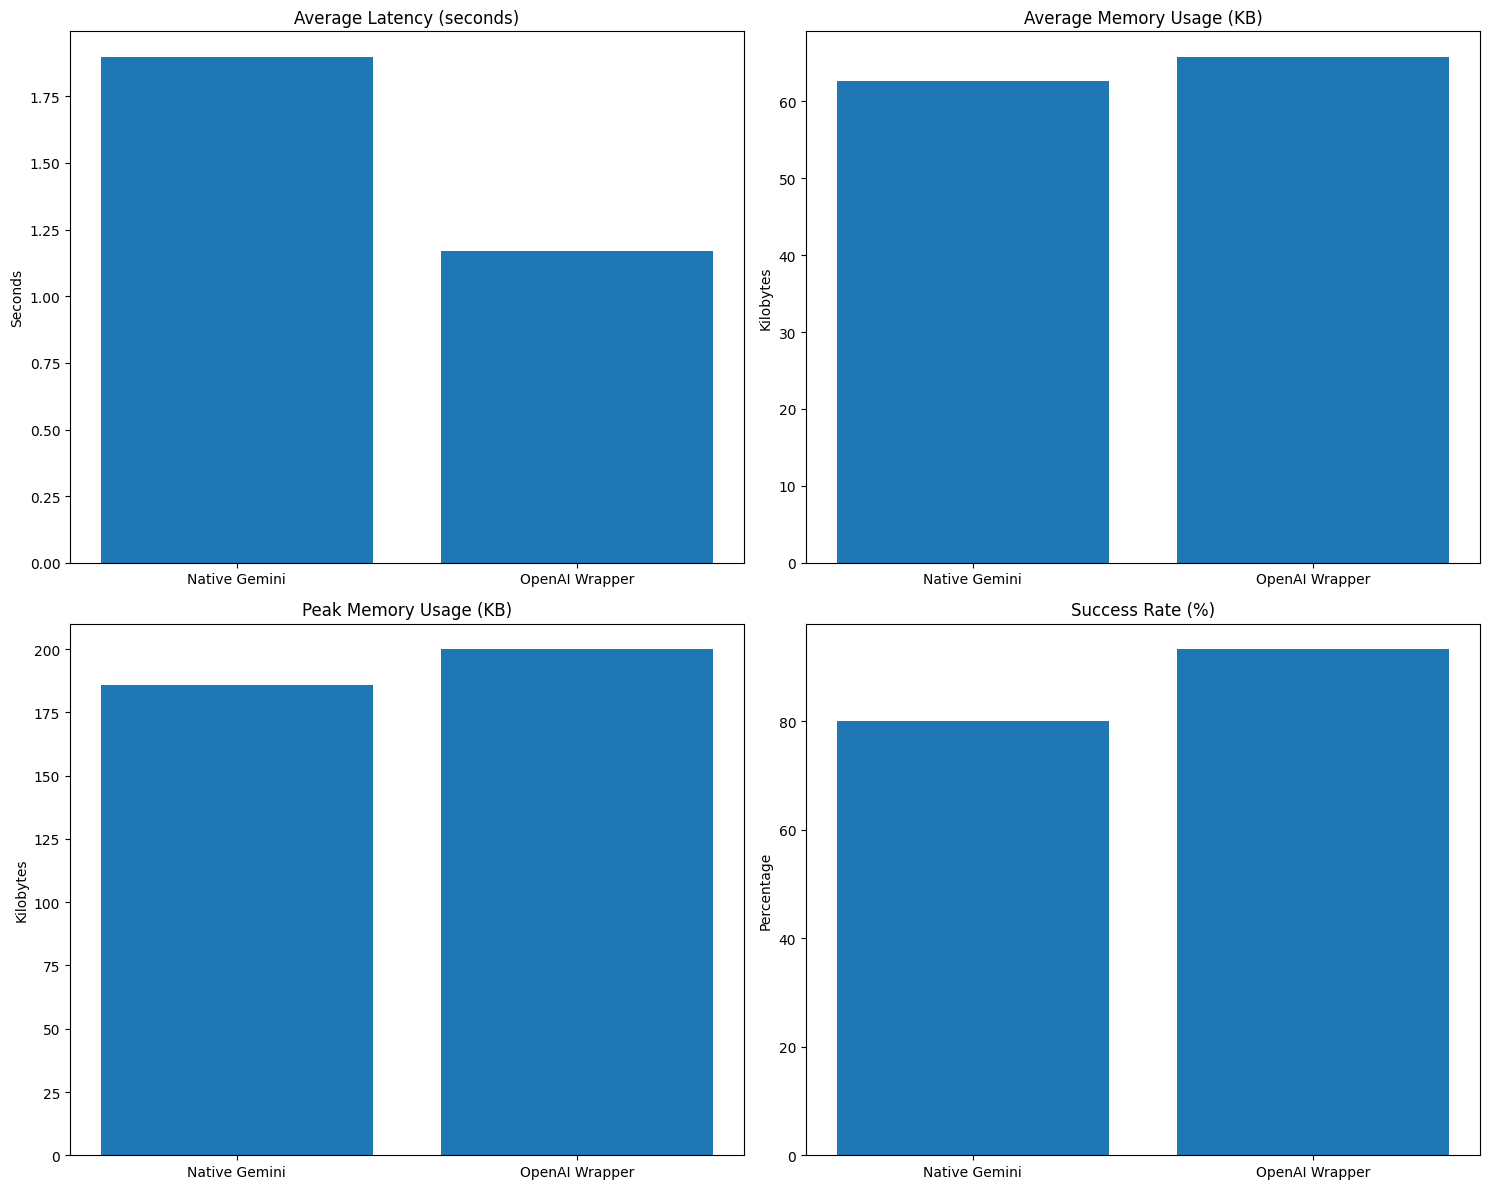

In [30]:
report, fig, raw_results = run_complete_benchmark(gemini_api_key)